In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
import json
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import plotly.graph_objects as go

warnings.filterwarnings("ignore")

from src.scripts.disease_plotting import (
    load_uniprotid_diseases,
    quantify_missing_diseases,
    add_keywords_when_comments_missing,
    sort_diseases,
)
from src.scripts.citations import (get_patent_citations_per_disease, calculate_patent_H_index_diseases, calculate_patent_H_index_targets)
from src.scripts import targets

In [2]:
usecols = [
    "BindingDB Reactant_set_id",
    # "Ligand SMILES",
    # "Ligand InChI",
    # "Ligand InChI Key",
    # "BindingDB MonomerID",
    # "BindingDB Ligand Name",
    # "Target Name",
    "Target Source Organism According to Curator or DataSource",
    # "Ki (nM)",
    # "IC50 (nM)",
    # "Kd (nM)",
    # "EC50 (nM)",
    # "kon (M-1-s-1)",
    # "koff (s-1)",
    # "pH",
    # "Temp (C)",
    # "Curation/DataSource",
    # "Article DOI",
    # "BindingDB Entry DOI",
    # "PMID",
    # "PubChem AID",
    "Patent Number",
    # "Authors",
    # "Institution",
    # "Ligand HET ID in PDB",
    # "PDB ID(s) for Ligand-Target Complex",
    # "PubChem CID",
    # "PubChem SID",
    # "ChEBI ID of Ligand",
    # "ChEMBL ID of Ligand",
    # "DrugBank ID of Ligand",
    # "IUPHAR_GRAC ID of Ligand",
    # "KEGG ID of Ligand",
    # "ZINC ID of Ligand",
    # "Number of Protein Chains in Target (>1 implies a multichain complex)",
    # "BindingDB Target Chain Sequence",
    # "PDB ID(s) of Target Chain",
    "UniProt (SwissProt) Recommended Name of Target Chain",
    "UniProt (SwissProt) Entry Name of Target Chain",
    "UniProt (SwissProt) Primary ID of Target Chain",
    "UniProt (TrEMBL) Primary ID of Target Chain",
    "UniProt (TrEMBL) Submitted Name of Target Chain",
]

In [3]:
df = pd.read_csv(
    r"../data/BindingDB_All.tsv",
    sep="\t",
    usecols=usecols,
)

In [4]:
with open("../src/data/patents.json", "r") as f:
    patents = json.load(f)
patents_df = pd.DataFrame(
    [
        {
            "patent": patent["patent"],
            "title": patent["info"].get("title", np.nan),
            "abstract": (patent["info"].get("abstract", "") or "").strip(),
            "url": patent["info"].get("url", np.nan),
            "status": patent["info"].get("status", np.nan),
            "families citing": int(patent["info"].get("families citing", 0) or 0),
            "cited by": int(patent["info"].get("cited by", 0) or 0),
        }
        for patent in patents
        if isinstance(patent, dict) and isinstance(patent.get("info"), dict)
    ]
)

In [5]:
patents_df["total citations"] = patents_df["families citing"] + patents_df["cited by"]
sorted_top_100 = patents_df.sort_values(by="total citations", ascending=False).head(100)

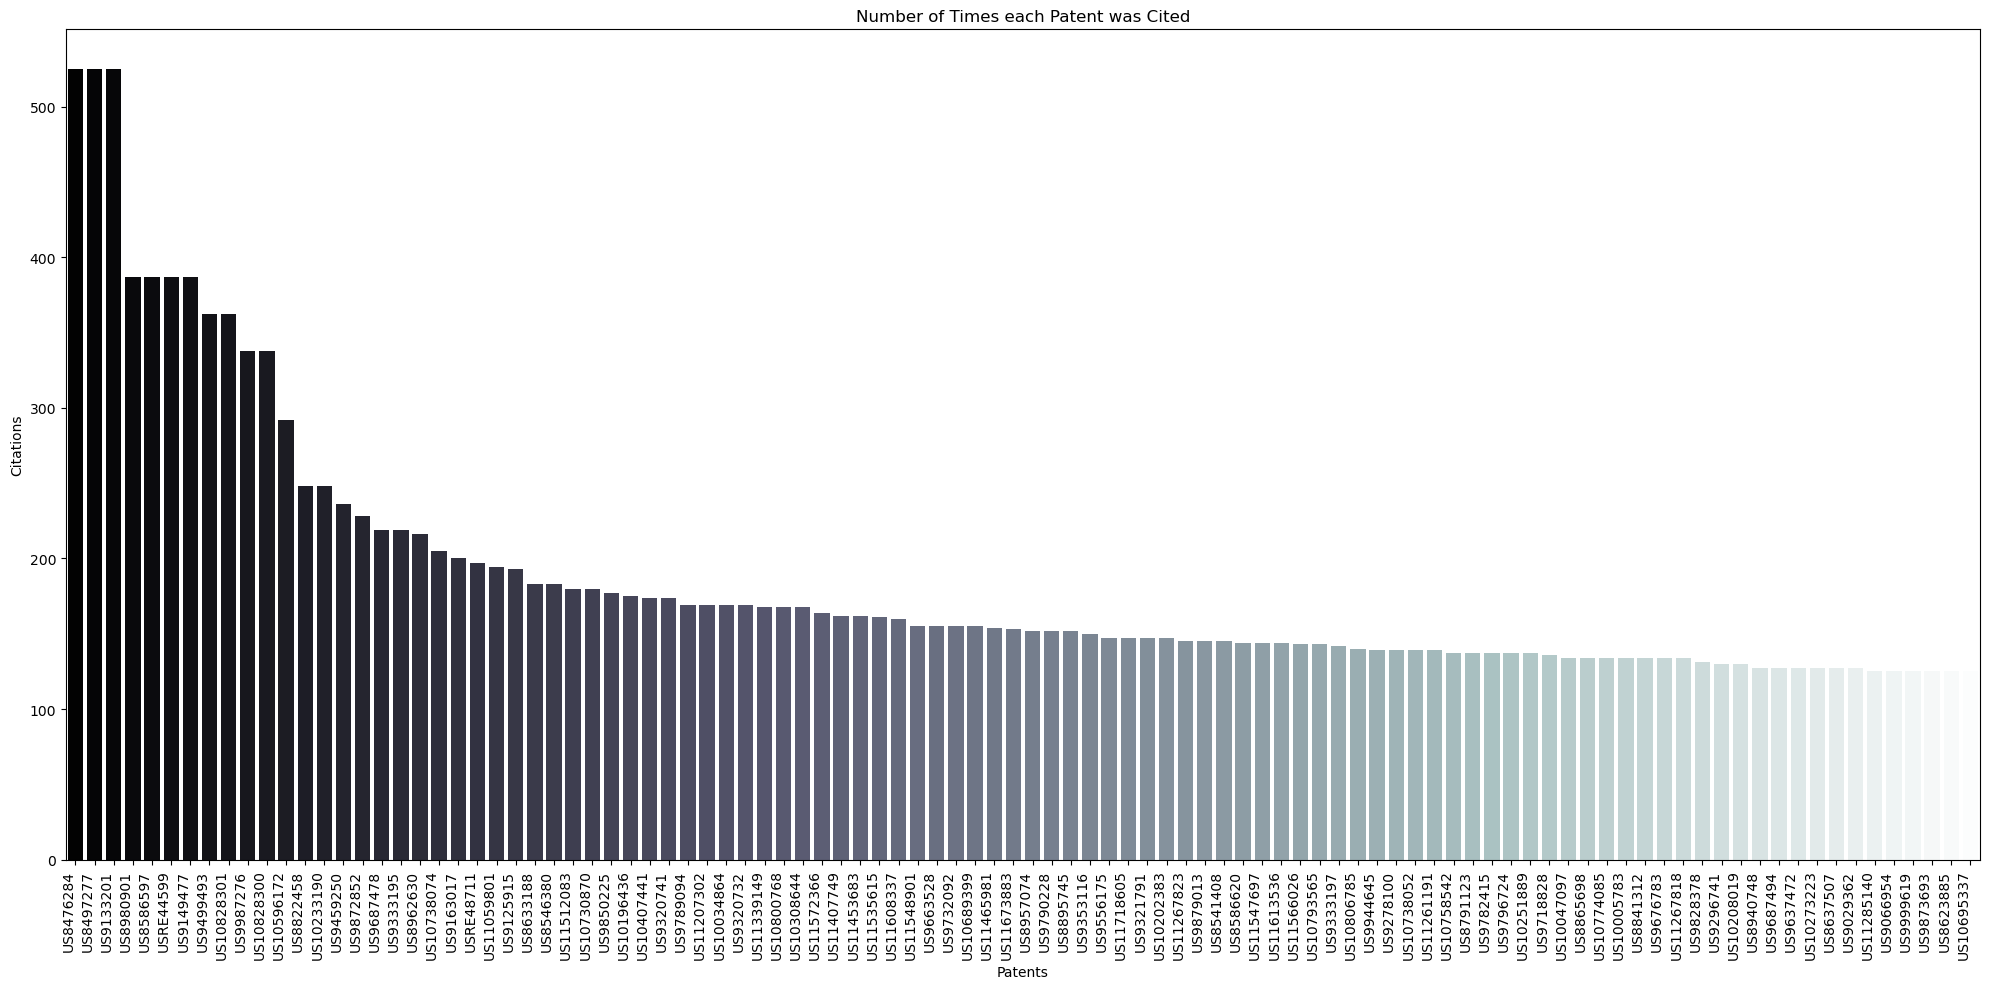

In [6]:
plt.figure(figsize=(20, 10))
sns.barplot(x="patent", y="total citations", data=sorted_top_100, palette="bone")
plt.xticks(rotation=90, ha="right")
plt.xlabel("Patents")
plt.ylabel("Citations")
plt.title("Number of Times each Patent was Cited")
plt.tight_layout()
plt.show()

# Disease classes:

In [7]:
diseases = load_uniprotid_diseases()
ids_missing_diseases, percentage_missing = quantify_missing_diseases(diseases)
diseases_df = add_keywords_when_comments_missing(diseases)
diseases_df = diseases_df.rename(columns={"comments_bfill": "diseases"})
diseases_df = diseases_df.dropna(subset="diseases").drop(
    columns=["comments", "keywords"]
)
diseases_df["Disease Classes"] = diseases_df["diseases"].apply(
    lambda l: [sort_diseases(l_i) for l_i in l]
)
disease_citations_df = get_patent_citations_per_disease(df, diseases_df, patents_df)

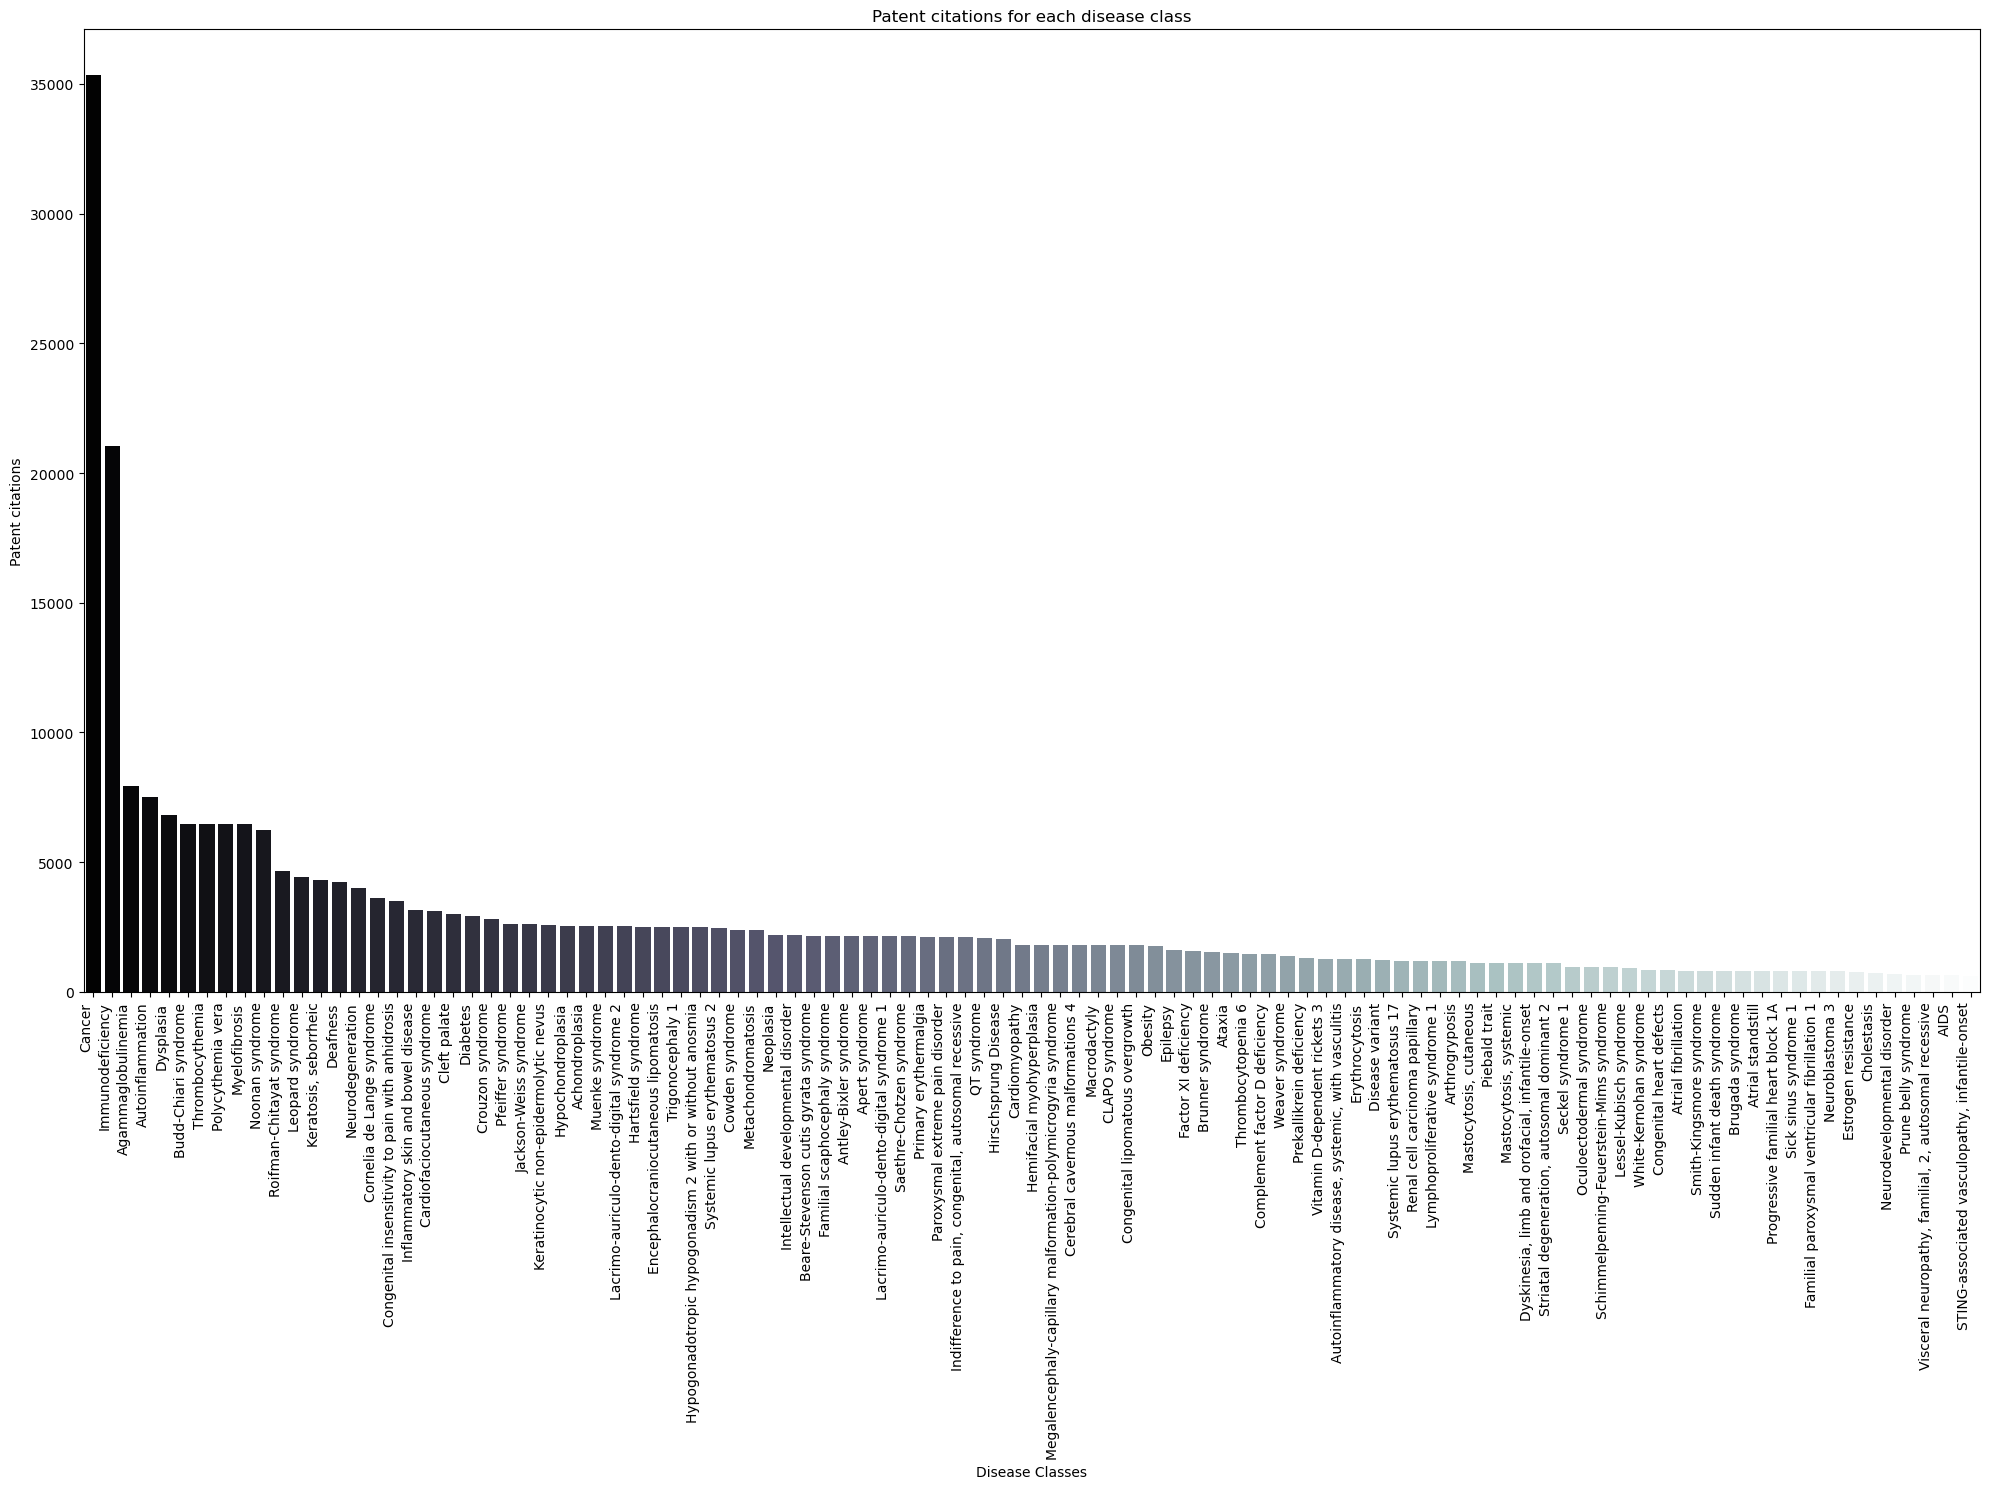

In [8]:
plt.figure(figsize=(20, 15))
sns.barplot(
    x="Disease Classes",
    y="Total Citations",
    data=disease_citations_df.head(100),
    palette="bone",
)
plt.xticks(rotation=90, ha="right")
plt.xlabel("Disease Classes")
plt.ylabel("Patent citations")
plt.title("Patent citations for each disease class")
plt.tight_layout()
plt.show()

In [9]:
colors = ['#F0BCD4']
fig = px.bar(
    disease_citations_df.head(10),
    x="Total Citations",
    y="Disease Classes",
    orientation='h',
    title="Patent Citations for each Disease Class",
    color_discrete_sequence=colors
)
fig.update_layout(
    xaxis_title="Patent Citations",
    yaxis_title="Disease Classes",
    xaxis=dict(
        tickmode='linear',
        tick0=0,  
        dtick=5000,  
        tickangle=0
    ),
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark",
)
fig.update_yaxes(
    categoryorder="total ascending",
)
fig.show()

In [10]:
disease_citations_df['Patents Count'] = disease_citations_df['Patent Number'].apply(len)
disease_citations_df = disease_citations_df.sort_values('Patents Count', ascending=False)
colors = ['#F0BCD4', '#A14A76'] 

fig = go.Figure()
fig.add_trace(
    go.Bar(
        y=disease_citations_df['Disease Classes'][0:10],
        x=disease_citations_df['Total Citations'][0:10],
        name='Total Citations',
        orientation='h',
        marker=dict(color=colors[0]),
        offsetgroup=1
    )
)
fig.add_trace(
    go.Bar(
        y=disease_citations_df['Disease Classes'][0:10],
        x=disease_citations_df['Patents Count'][0:10],
        name='Patents Count',
        orientation='h',
        marker=dict(color=colors[1]),
        offsetgroup=2,
        xaxis='x2'
    )
)
fig.update_layout(
    title="Distribution of Patents and Citations per Disease Class",
    title_x=0.5,
    title_y=0.95,
    yaxis=dict(
        title="Disease Classes",
        categoryorder="array",
        categoryarray=disease_citations_df['Disease Classes'][0:10][::-1] 
    ),
    xaxis=dict(
        title="Total Citations",
        titlefont=dict(color=colors[0]),
        tickfont=dict(color=colors[0])
    ),
    xaxis2=dict(
        title="Patents Count",
        titlefont=dict(color=colors[1]),
        tickfont=dict(color=colors[1]),
        overlaying='x', 
        side='top',
        position=1
    ),
    barmode='group',
    legend=dict(x=1, y=1, traceorder='normal', orientation='v'),
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template='plotly_dark'
)
fig.show()

In [11]:
# custom_style = """
# <style>
#   body, html {
#     background-color: rgb(34, 37, 41);
#   }
# </style>
# """

# # Save the HTML file and inject the custom style
# html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# # Insert the style in the <head>
# html_content = html_content.replace("</head>", f"{custom_style}</head>")

# # Write to a file
# with open("Patents_Diseases.html", "w") as f:
#     f.write(html_content)

# fig.write_image("Patents_Diseases.svg")

In [12]:
disease_h_index_df= calculate_patent_H_index_diseases(disease_citations_df)

In [13]:
colors = ['#DE9151']
fig = px.bar(
    disease_h_index_df[0:10],
    x="H-Index",
    y="Disease Classes",
    orientation='h',
    title="Patent H-Index per Disease Class",
    log_x=True,
    color_discrete_sequence=colors
)
fig.update_layout(
    yaxis_title="Disease Classes",
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.update_yaxes(categoryorder="total ascending")
fig.show()

In [14]:
# custom_style = """
# <style>
#   body, html {
#     background-color: rgb(34, 37, 41);
#   }
# </style>
# """

# # Save the HTML file and inject the custom style
# html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# # Insert the style in the <head>
# html_content = html_content.replace("</head>", f"{custom_style}</head>")

# # Write to a file
# with open("Patents_HIndex_Diseases.html", "w") as f:
#     f.write(html_content)

# fig.write_image("Patents_HIndex_Diseases.svg")

In [15]:
disease_citations_df["Patent status"] = disease_citations_df["Patent Number"].apply(
    lambda patents: list(patents_df.loc[patents_df["patent"].isin(patents), "status"])
)
exploded_df = disease_citations_df.head(100).explode("Patent status")
status_counts = (
    exploded_df.groupby(["Disease Classes", "Patent status"])
    .size()
    .unstack(fill_value=0)
)
status_counts = status_counts.drop(columns=["N/A"])
disease_citations_df = disease_citations_df.sort_values(by ="Patents Count", ascending=False)
top_10_diseases = disease_citations_df["Disease Classes"].head(10)
filtered_counts = status_counts.loc[top_10_diseases]
long_data = filtered_counts.reset_index().melt(
    id_vars="Disease Classes", var_name="Patent Status", value_name="Count"
)

In [16]:
fig = px.bar(
    long_data,
    x="Disease Classes",
    y="Count",
    color="Patent Status",
    title="Patent Status for Top 10 Most Cited Diseases",
    color_discrete_sequence=px.colors.sequential.Plasma,
)
fig.update_layout(
    xaxis_title="Disease Classes",
    yaxis_title="Patent Status Counts",
    legend_title="Patent Status",
    barmode="stack",
    xaxis_tickangle=45,
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.show()

In [17]:
# custom_style = """
# <style>
#   body, html {
#     background-color: rgb(34, 37, 41);
#   }
# </style>
# """

# # Save the HTML file and inject the custom style
# html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# # Insert the style in the <head>
# html_content = html_content.replace("</head>", f"{custom_style}</head>")

# # Write to a file
# with open("Patent_Status_Diseases.html", "w") as f:
#     f.write(html_content)

# fig.write_image("Patent_Status_Diseases.svg")

# Target classes:

In [18]:
mapped_names = targets.get_target_class(names_df=df)
merged = df.merge(mapped_names, left_index=True, right_index=True)
merged = merged.dropna(subset="Patent Number")
target_dois = (
    merged.groupby("UniProt (SwissProt) Recommended Name of Target Chain_y")["Patent Number"].apply(set).reset_index()
)
patents_dict = patents_df.set_index('patent')['total citations'].to_dict()
target_citations_exp = []
for index, row in target_dois.iterrows():
    target_class = row['UniProt (SwissProt) Recommended Name of Target Chain_y']
    patents = row["Patent Number"]
    citations_list = []
    for patent in patents: 
        citation_count = patents_dict.get(patent, 0)  # 0 if DOI not found
        citations_list.append({"Patent": patent, "Citations": citation_count})
    target_citations_exp.append(
        {"Target Classes": target_class, "Citations": citations_list}
    )
target_citations_df = pd.DataFrame(target_citations_exp)

In [19]:
target_h_index_df = calculate_patent_H_index_targets(target_citations_df)

In [20]:
colors = ['#6F584B']
fig = px.bar(
    target_h_index_df[0:10],
    x="H-Index",
    y="Target Classes",
    orientation='h',
    title="Patent H-Index per Target Class",
    log_x=True,
    color_discrete_sequence=colors
)
fig.update_layout(
    yaxis_title="Target Classes",
    title_x=0.5,
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template="plotly_dark"
)
fig.update_yaxes(categoryorder="total ascending")
fig.show()

In [21]:
# custom_style = """
# <style>
#   body, html {
#     background-color: rgb(34, 37, 41);
#   }
# </style>
# """

# # Save the HTML file and inject the custom style
# html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# # Insert the style in the <head>
# html_content = html_content.replace("</head>", f"{custom_style}</head>")

# # Write to a file
# with open("Patents_HIndex_Target.html", "w") as f:
#     f.write(html_content)

# fig.write_image("Patents_HIndex_Target.svg")

In [22]:
target_citations_df["Patent Count"] = target_citations_df["Citations"].apply(len)
target_citations_df["Total Citations"] = target_citations_df["Citations"].apply(
    lambda citations: sum(citation.get("Citations", 0) or 0 for citation in citations)
)
target_sorted_citations = target_citations_df.sort_values(by="Total Citations", ascending=False)
target_sorted_patents = target_citations_df.sort_values(by="Patent Count", ascending=False)

In [23]:
top_10_citations = target_sorted_citations.head(10)
top_10_patents = target_sorted_patents.head(10)
top_10_union = pd.concat([top_10_citations['Target Classes'], top_10_patents['Target Classes']]).drop_duplicates()
top_10_union.reset_index(drop=True, inplace=True)
corresp_citations = target_sorted_citations[target_sorted_citations['Target Classes'].isin(top_10_union)]
corresp_patents = target_sorted_patents[target_sorted_patents['Target Classes'].isin(top_10_union)]
union = pd.concat([corresp_citations, corresp_patents]).drop_duplicates(subset='Target Classes')
union.reset_index(drop=True, inplace=True)
union = union.sort_values(by="Patent Count", ascending=False)
union

,Target Classes,Citations,Patent Count,Total Citations
0,Non Receptor Tyr Kinase,"[{'Patent': 'US9133134', 'Citations': 17}, {'P...",618,19967
2,Other Protein Kinase,"[{'Patent': 'US9351965', 'Citations': 11}, {'P...",465,10027
1,Growth Factor Receptor,"[{'Patent': 'US10994015', 'Citations': 97}, {'...",437,13228
8,Neurotransmitter receptor,"[{'Patent': 'US8846730', 'Citations': 14}, {'P...",317,3202
5,Ion Channel,"[{'Patent': 'US11919887', 'Citations': 22}, {'...",311,5606
3,Histone Modifier,"[{'Patent': 'US11312726', 'Citations': 5}, {'P...",285,7731
6,Phosphodiesterase,"[{'Patent': 'US10562916', 'Citations': 63}, {'...",246,3600
4,Phosphatidylinositol Kinase,"[{'Patent': 'US9321773', 'Citations': 26}, {'P...",186,5795
11,Hormone Receptor,"[{'Patent': 'US9796720', 'Citations': 2}, {'Pa...",185,2845
10,Polyprotein,"[{'Patent': 'US8987272', 'Citations': 5}, {'Pa...",139,3080


In [24]:
colors = ["#ABC4AB", "#FF785A"]
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y=union['Target Classes'],
        x=union['Total Citations'],
        name='Total Citations',
        orientation='h',
        marker=dict(color=colors[0]),
        offsetgroup=1
    )
)
fig.add_trace(
    go.Bar(
        y=union['Target Classes'],
        x=union['Patent Count'],
        name='Patent Count',
        orientation='h',
        marker=dict(color=colors[1]),
        offsetgroup=2,
        xaxis='x2'
    )
)
fig.update_layout(
    title="Distribution of Patents and Citations per Target Class",
    title_x=0.5,
    title_y=0.95,
    yaxis=dict(
        title="Target Classes",
        categoryorder="array",
        categoryarray=union['Target Classes'][::-1] 
    ),
    xaxis=dict(
        title="Total Citations",
        titlefont=dict(color=colors[0]),
        tickfont=dict(color=colors[0])
    ),
    xaxis2=dict(
        title="Patent Count",
        titlefont=dict(color=colors[1]),
        tickfont=dict(color=colors[1]),
        overlaying='x', 
        side='top',
        position=1
    ),
    barmode='group',
    legend=dict(x=1, y=1, traceorder='normal', orientation='v'),
    plot_bgcolor="rgb(34, 37, 41)", paper_bgcolor="rgb(34, 37, 41)",
    template='plotly_dark'
)
fig.show()

In [25]:
# custom_style = """
# <style>
#   body, html {
#     background-color: rgb(34, 37, 41);
#   }
# </style>
# """

# # Save the HTML file and inject the custom style
# html_content = fig.to_html(full_html=True, include_plotlyjs="cdn")
# # Insert the style in the <head>
# html_content = html_content.replace("</head>", f"{custom_style}</head>")

# # Write to a file
# with open("Patents_Citations_Target.html", "w") as f:
#     f.write(html_content)

# fig.write_image("Patents_Citations_Target.svg")